In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
url = 'KOSPI 200 과거 금리 - Investing.com.html'
tables = pd.read_html(url, encoding='cp949', index_col=0) # 1번째 컬럼이 index다.

In [4]:
len(tables)

13

In [5]:
df = tables[0]

In [6]:
df.head()

,현재가,오픈,고가,저가,거래량,변동 %
날짜,,,,,,
2019년 07월 02일,275.97,276.06,277.46,274.63,64.74K,-0.47%
2019년 07월 01일,277.27,279.59,279.68,276.85,73.43K,-0.08%
2019년 06월 28일,277.50,278.03,278.56,276.58,67.60M,-0.09%
2019년 06월 27일,277.75,275.47,278.63,275.09,66.30M,0.81%
2019년 06월 26일,275.53,275.21,276.36,274.66,58.82M,0.09%


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 488 entries, 2019년 07월 02일 to 2017년 07월 03일
Data columns (total 6 columns):
현재가     488 non-null float64
오픈      488 non-null float64
고가      488 non-null float64
저가      488 non-null float64
거래량     488 non-null object
변동 %    488 non-null object
dtypes: float64(4), object(2)
memory usage: 26.7+ KB


In [8]:
현재가 = df['현재가']

In [9]:
현재가.shape

(488,)

In [10]:
window_weak = 4
window_day = window_weak * 5 # 20일
predict_day = 5

X, Y 갯수 체크
- 데이터가 30개 있으면? 20개로부터 5일 예측하므로 (20+5)=1샘플, 총 6샘플
  - 참조해야할일 : window_day(1주에 5일 * 4주) = 20일
  - 예측일 : predict_day = 5
  - 샘플 생성 수식 :  len(df2) - (predict_day + window_day -1)
  - 30 - (5 + 20 -1) = 6
  - 1샘플 : 1~20 + 21~25, 2샘플 : 2~21 + 22~26, 3샘플 : 3~22 + 23~27, 6샘플: 6~25 + 26~30
- 현재 데이터 488개 샘플, 총 464쌍의 X,Y를 만들어야 합니다.
  - 샘플 생성 수식 :  len(df2) - (predict_day + window_day -1)
  - 488 - (5 + 20 -1) = 464
  - X[464, 2 * 20]

In [11]:
offset = window_day+predict_day-1
offset, len(현재가)-offset

(24, 464)

In [12]:
before = 현재가.iloc[:-predict_day] # 최근 데이터 5개 빼고
before.shape

(483,)

In [13]:
later = 현재가.iloc[window_day:] # 과거 데이터 20개 빼고
later.shape

(468,)

In [14]:
m = len(현재가) - (predict_day + window_day -1)
m

464

In [15]:
x_list = []
y_list = []
for i in range(m):
    x = 현재가.iloc[i:i+window_day]  # 20일간의 데이터
    y = 현재가.iloc[i+window_day:i+window_day+predict_day]  # 그다음 5일간의 데이터
    x_list.append(x.values)         # 날짜 인덱스 빼고 값만 저장
    y_list.append(y.values)

In [16]:
X = np.array(x_list)
y = np.array(y_list)
X.shape, y.shape  #(m-instance, day, 특징수(달러, 엔화))

((464, 20), (464, 5))

In [17]:
# 2차원으로 변환
X = np.reshape(X,[m, -1])
y = np.reshape(y,[m, -1])

In [18]:
X.shape, y.shape # (달러, 엔화, 달러, 엔화....)

((464, 20), (464, 5))

In [19]:
# train /test 분리
offset = 30 # 테스트셋
X_train = X[offset:]
X_test = X[:offset]
y_train = y[offset:]
y_test = y[:offset]

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((434, 20), (30, 20), (434, 5), (30, 5))

In [21]:
# 모델 선택, 학습
from sklearn.linear_model import LinearRegression, Ridge, Lasso
lr = Ridge().fit(X_train, y_train)

In [22]:
# 성능 측정
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9564470406278675, 0.7752936936256805)

In [30]:
# 미래의 5일 환율 예측을 그래프로 시각화
최근20일데이터 = 현재가.iloc[-window_day:].values.reshape([1,-1])
미래의5일예측 = lr.predict(최근20일데이터)
미래의5일예측 = np.reshape(미래의5일예측,predict_day)
미래의5일예측.shape

(5,)

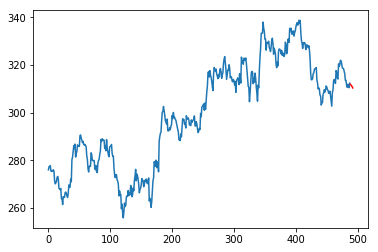

In [24]:
# 예측을 그리프로 시각화
x_num = np.arange(len(현재가))
x1_num = np.arange(len(현재가), len(현재가) + len(미래의5일예측))

plt.plot(x_num, 현재가)
plt.plot(x1_num, 미래의5일예측, c='red')

In [25]:
현재가.shape

(488,)

In [26]:
최근20일데이터.shape

(1, 20)

In [28]:
현재가.iloc[-window_day:].values.shape

(20,)